In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size


Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
from keras.applications import MobileNetV2 
from keras.models import Model 
import keras 


mobilnetv2 = MobileNetV2 (include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

mobilnetv2.trainable = True



C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in mobilnetv2.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000029084AD39C8>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x0000029084AA3888>,Conv1_pad,True
2,<keras.layers.convolutional.Conv2D object at 0x00000290FA85FD08>,Conv1,True
3,<keras.layers.normalization.BatchNormalization object at 0x0000029085134988>,bn_Conv1,True
4,<keras.layers.advanced_activations.ReLU object at 0x0000029085134708>,Conv1_relu,True
...,...,...,...
150,<keras.layers.convolutional.Conv2D object at 0x0000029364AB4288>,block_16_project,True
151,<keras.layers.normalization.BatchNormalization object at 0x0000029364AD0848>,block_16_project_BN,True
152,<keras.layers.convolutional.Conv2D object at 0x000002908BCDC1C8>,Conv_1,True
153,<keras.layers.normalization.BatchNormalization object at 0x0000029364B1ACC8>,Conv_1_bn,True


In [7]:
print(mobilnetv2.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
mobilnetv2

In [29]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D 
from keras.models import Sequential 
from keras import optimizers  
import tensorflow as tf

# build model architecture 
model =Sequential() 

model.add(mobilnetv2)
model.add(Flatten()) 
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.25)) 
model.add(Dense(num_class, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [30]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 163842    
Total params: 2,421,826
Trainable params: 2,387,714
Non-trainable params: 34,112
_________________________________________________________________
None


In [32]:
history = model.fit_generator(train,
                              epochs=10,  
                              validation_data=val,  
                              verbose=1)

Epoch 1/10
454/454 [==============================] - 203s 446ms/step - loss: 0.3752 - accuracy: 0.9429 - f1_m: 0.9375 - precision_m: 0.9364 - recall_m: 0.9394 - val_loss: 0.5516 - val_accuracy: 0.6318 - val_f1_m: 0.6396 - val_precision_m: 0.6313 - val_recall_m: 0.6490
Epoch 2/10
454/454 [==============================] - 203s 448ms/step - loss: 0.3580 - accuracy: 0.9587 - f1_m: 0.9552 - precision_m: 0.9546 - recall_m: 0.9563 - val_loss: 0.5634 - val_accuracy: 0.7527 - val_f1_m: 0.7536 - val_precision_m: 0.7528 - val_recall_m: 0.7555
Epoch 3/10
454/454 [==============================] - 202s 446ms/step - loss: 0.3495 - accuracy: 0.9667 - f1_m: 0.9638 - precision_m: 0.9627 - recall_m: 0.9654 - val_loss: 0.4915 - val_accuracy: 0.8285 - val_f1_m: 0.8300 - val_precision_m: 0.8233 - val_recall_m: 0.8379
Epoch 4/10
454/454 [==============================] - 208s 459ms/step - loss: 0.3432 - accuracy: 0.9737 - f1_m: 0.9712 - precision_m: 0.9703 - recall_m: 0.9724 - val_loss: 0.3430 - val_accur

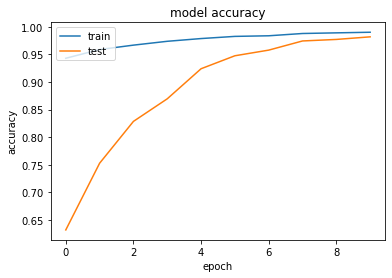

In [33]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

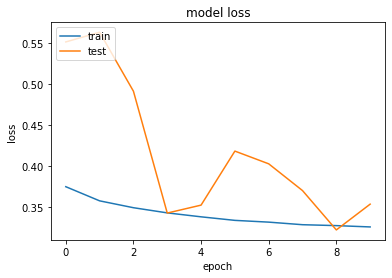

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

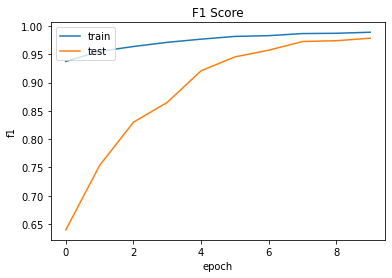

In [35]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

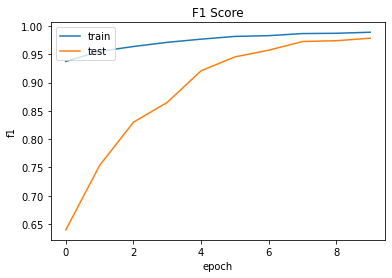

In [36]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

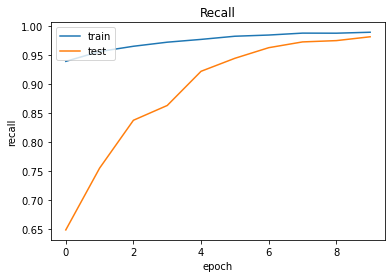

In [37]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

142/142 [==============================] - 13s 92ms/step
El modelo predice el  98.0595350265503 % de los datos
